# Setup

In [29]:
%load_ext autoreload
%autoreload 2
from dsets.dsets import ENGLISH_DATASETS, get_datasets
from dsets.dset_config.dset_config import DatasetConfig

from dsets.helpers.helpers import apply_parallel, get_sampling_rates
from itpsaudio.transforms import * 
from itpsaudio.aug_transforms import * 
from itpsaudio.callbacks import MixedPrecisionTransformers
from itpsaudio.core import * 
import os
os.chdir("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports 

In [2]:
from fastai.data.all import * 
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForMaskedLM, AutoTokenizer, Wav2Vec2Processor, Wav2Vec2ForCTC
from fastai.text.all import * 
from fastai.vision.all import *
from fastai.callback.tensorboard import *
import torchaudio
import pandas
from pathlib import Path
from IPython.display import Audio, display
from datasets import load_metric
wer_metric = load_metric("wer")
dset_lengths = None

In [3]:
dev_set = DatasetConfig(name="librispeech", split="dev", kind="clean")
p, df = get_datasets([dev_set], force_download=False)

# Model Training

In [4]:
def get_audio_length(s):
    t, sr = torchaudio.load(s)
    return len(t[0])/sr

In [5]:
df["audio_length"] = df["filename"].apply(get_audio_length)

In [6]:
df["audio_length"].max()

32.645

<AxesSubplot:ylabel='Frequency'>

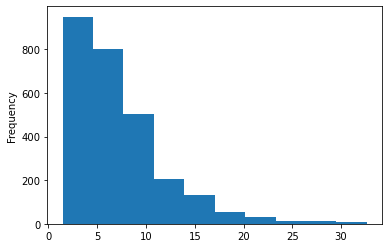

In [7]:
df["audio_length"].plot.hist()

In [8]:
df["audio_length"].sum() / 60 / 60

5.3878113194444435

In [9]:
df = df[df["audio_length"]<5].reset_index(drop=True)
df = df[~df["text"].isna()].reset_index(drop=True)

In [10]:
df["audio_length"].sum() / 60 / 60

1.0754069965277777

<AxesSubplot:ylabel='Frequency'>

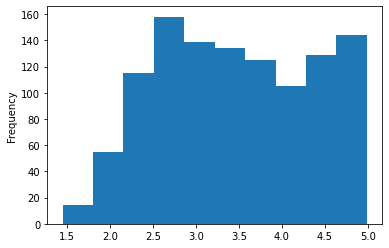

In [11]:
df["audio_length"].plot.hist()

In [12]:
# from transformers import HubertForCTC
# pretrained_model_name = "facebook/hubert-large-ls960-ft"
# model = HubertForCTC.from_pretrained(pretrained_model_name)
splits=RandomSplitter(valid_pct=0.2)(df)


In [13]:
dataroot=Path("/")
pretrained_model_name = "facebook/wav2vec2-base-960h"

processor = Wav2Vec2Processor.from_pretrained(pretrained_model_name)

tok = TransformersTokenizer(processor)
dataroot=Path("/")
abt = AudioBatchTransform(dataroot, df)
tfms = TfmdLists(df, abt, splits=splits)

In [14]:
train_text_lens = df.loc[splits[0], "audio_length"].to_list()
val_text_lens = df.loc[splits[1], "audio_length"].to_list()
srtd_dl=partial(SortedDL, res = train_text_lens)
dl_kwargs = [{},{'val_res': val_text_lens}]
dls = tfms.dataloaders(bs=6,
                        after_item=[capitalize, tok,
                                    RandomReverbration(p=0.1),
                                    AddNoise(range(1,4), noise, p=0.5), 
                                    ],
                        before_batch=[
                                      Pad_Audio_Batch(pad_idx_audio=0, pad_idx_text=-100,
                                                      pad_first=True,
                                                      seq_len=1),
                                       squeeze,
                                      ],
                        shuffle=True,
                        n_inp=1,
                        # res=df[df["train"]]["audio_length"].to_list(),
                        dl_type=srtd_dl)

In [15]:
model = Wav2Vec2ForCTC.from_pretrained(

    pretrained_model_name,
    # Path("/content/drive/MyDrive/data/models/english/librivox/librispeech_en_960hbase"),
    # attention_dropout=0.08,
    # hidden_dropout=0.08,
    # feat_proj_dropout=0.08,
    # mask_time_prob=0.05,
    # layerdrop=0.08,
    # ctc_loss_reduction="mean", 
    ctc_zero_infinity=True,
    # pad_token_id=processor.tokenizer.pad_token_id,
    # vocab_size=len(processor.tokenizer),
).cuda()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"

In [17]:
with open("noise_sample.wav", "wb") as f:
    r = requests.get(SAMPLE_NOISE_URL)
    f.write(r.content)

In [18]:
import torchaudio.transforms as T

In [19]:
noise,sr = torchaudio.load("noise_sample.wav")
noise = TensorAudio(noise, sr=sr)
noise.shape

torch.Size([1, 80000])

In [20]:
from itpsaudio.aug_transforms import AddNoise, RandomReverbration
from itpsaudio.transforms import squeeze, capitalize
train_text_lens = df.loc[splits[0], "audio_length"].to_list()
val_text_lens = df.loc[splits[1], "audio_length"].to_list()
srtd_dl=partial(SortedDL, res = train_text_lens)
dl_kwargs = [{},{'val_res': val_text_lens}]


dls = tfms.dataloaders(bs=3,
                        after_item=[capitalize, tok,
                                    RandomReverbration(p=0.1),
                                    AddNoise(range(0, 4), noise, p=0.5)
                                    ],
                        before_batch=[Pad_Audio_Batch(pad_idx_audio=0, pad_idx_text=-100,
                                                      pad_first=True,
                                                      seq_len=1),
                                       squeeze,
                                      ],
                        shuffle=True,
                        n_inp=1,
                        # res=df[df["train"]]["audio_length"].to_list(),
                        dl_type=srtd_dl,
                        dl_kargs=dl_kwargs
                      )

/home/jjs/.conda/envs/itps-env/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


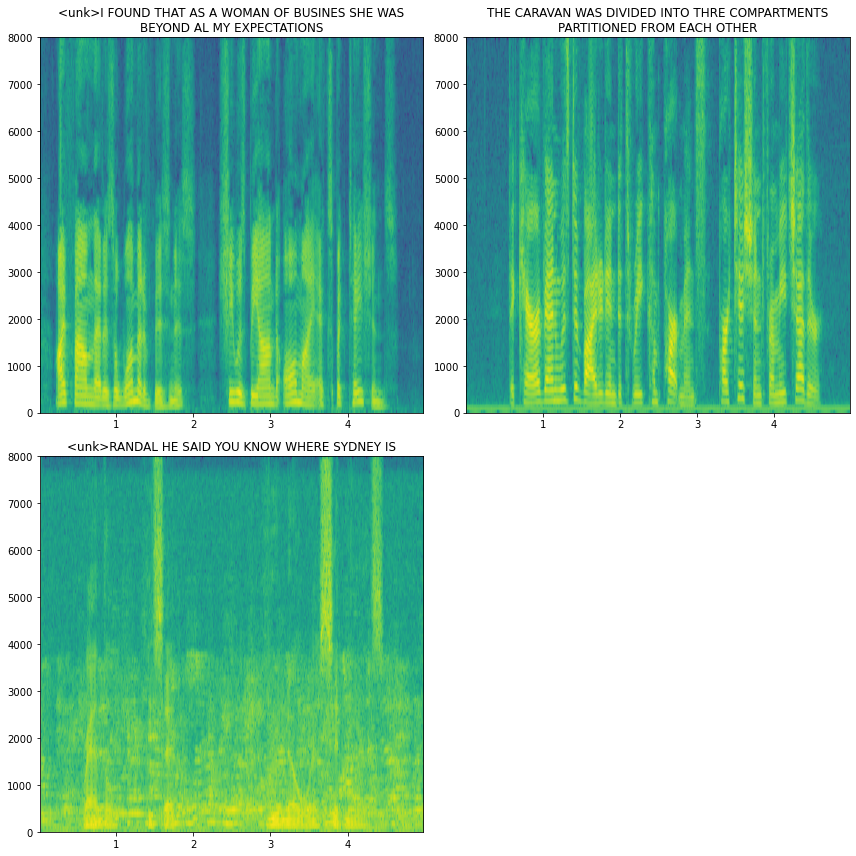

In [21]:
dls.show_batch(tok=tok)

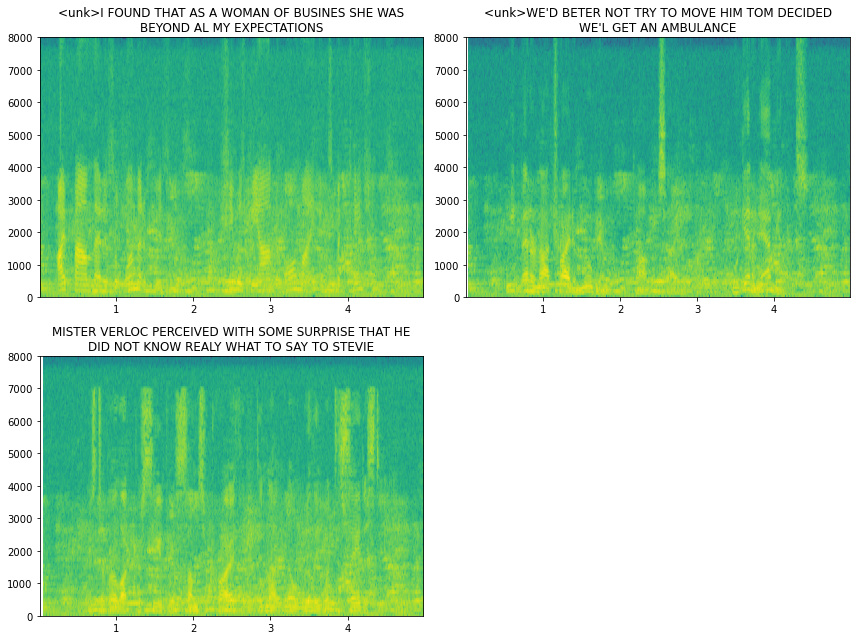

In [22]:
dls.show_batch(tok=tok, unique=False, max_n=6)

In [24]:
def wer(pred, labels):
    pred_logits = pred.logits
    pred_ids = np.argmax(pred_logits.cpu().numpy(), axis=-1)
    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(labels, group_tokens=False)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return wer

class TransformersLearner(Learner):
    def _do_one_batch(self):
        self.pred = self.model(self.xb[0], labels=cast(self.yb[0], torch.Tensor))
        self('after_pred')
        self.loss_grad = self.pred["loss"]
        self.loss = self.loss_grad.clone()
        self.smooth_loss = self.loss_grad.clone()
        self('after_loss')
        if not self.training or not len(self.yb): return
        self('before_backward')
        self.loss_grad.backward()
        self._with_events(self.opt.step, 'step', CancelStepException)
        self.opt.zero_grad()

In [25]:
logdir = Path("/content/drive/MyDrive/data/logs/audio_en/wav2vec2")
modelpath=Path("/content/drive/MyDrive/data/models/")
cbs=[TensorBoardCallback(log_dir=logdir,trace_model=False,log_preds=False),
     SaveModelCallback(comp=np.less,
                       monitor="wer",
                       fname=Path(modelpath/ "audio_en"/"wav2vec2")), 
      MixedPrecisionTransformers(),
    #  EarlyStoppingCallback(comp=np.less,
                          #  monitor="wer",
                          #  patience=10)
     ]

learn = TransformersLearner(dls, model,
                loss_func=noop, # Loss is calculated in Transformers internally
                metrics=[Perplexity(), wer ],
                cbs=cbs)

In [26]:
import gc
torch.cuda.empty_cache()
gc.collect()

10909

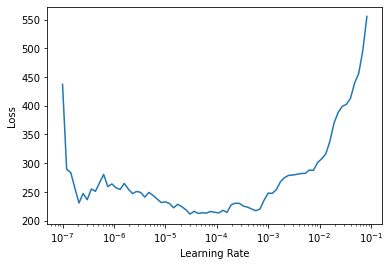

In [27]:
start_lr=1e-7
end_lr=10

r = learn.lr_find(start_lr=start_lr, end_lr=end_lr, num_it=100, stop_div=True, suggest_funcs=())

In [ ]:
learn.fit_one_cycle(10, lr_max=3e-4)

epoch,train_loss,valid_loss,perplexity,wer,time
0,156.745621,21.893793,3223692032.000000,0.065665,2:01:34
1,139.819031,20.651308,930570176.000000,0.064346,1:39:08
2,111.227364,20.831244,1114022912.000000,0.065012,1:38:07
3,106.214340,21.109535,1471480960.000000,0.064445,1:37:57
4,108.572556,20.915545,1212008192.000000,0.064010,1:37:39
5,104.111969,20.376886,707244032.000000,0.063159,1:37:03
6,97.112656,20.066401,518474048.000000,0.062889,1:37:02


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with wer value: 0.0656646876719141.
Better model found at epoch 1 with wer value: 0.06434643642589043.
Better model found at epoch 4 with wer value: 0.06400982485035764.
Better model found at epoch 5 with wer value: 0.06315893227520908.
Better model found at epoch 6 with wer value: 0.0628894519229561.


epoch,train_loss,valid_loss,perplexity,wer,time
0,156.745621,21.893793,3223692032.000000,0.065665,2:01:34
1,139.819031,20.651308,930570176.000000,0.064346,1:39:08
2,111.227364,20.831244,1114022912.000000,0.065012,1:38:07
3,106.214340,21.109535,1471480960.000000,0.064445,1:37:57
4,108.572556,20.915545,1212008192.000000,0.064010,1:37:39
5,104.111969,20.376886,707244032.000000,0.063159,1:37:03
6,97.112656,20.066401,518474048.000000,0.062889,1:37:02


In [ ]:
learn.save("/content/drive/MyDrive/data/models/wav2vecaug_cp",
           with_opt=True)

In [ ]:
itps_en_test = DatasetConfig(name="itps", split="train",lang="en")
p, df = get_datasets([itps_en_test])


df["audio_length"] = apply_parallel(df["filename"], get_audio_length, 16)
df = df[df["audio_length"]<15].reset_index(drop=True)
df = df[~df["text"].isna()].reset_index(drop=True)

abt = AudioBatchTransform(dataroot, df)
tfms = TfmdLists(df, abt)

In [ ]:
test_dls = tfms.dataloaders(bs=6, after_item=[capitalize, tok,
                                    # RandomReverbration(p=0.2),
                                    ],
                        before_batch=[#AddN(), 
                                      Pad_Audio_Batch(pad_idx_audio=0, pad_idx_text=-100,
                                                      pad_first=True,
                                                      seq_len=1),
                                       squeeze,
                                      ],
                        n_inp=1,
                        dl_type=srtd_dl)
learn.dls = test_dls

learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,perplexity,wer,time
0,77.560326,27.183392,639141412864.000000,0.057673,1:36:11


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with wer value: 0.05767348131277699.


In [ ]:
from datasets import load_dataset
import soundfile as sf

librispeech_eval = load_dataset("librispeech_asr", "clean", split="test")

def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

librispeech_eval = librispeech_eval.map(map_to_array)

def map_to_pred(batch):
    input_values = processor(batch["speech"], return_tensors="pt", padding="longest", sampling_rate=16000).input_values
    with torch.no_grad():
        logits = model(input_values.to("cuda")).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["transcription"] = transcription
    return batch
    
result = librispeech_eval.map(map_to_pred, batched=True, batch_size=1, remove_columns=["speech"])
print("WER:", wer_metric.compute(references=result["text"],
                                  predictions=result["transcription"]))